In [1]:
import numpy as np
import time 
import os, sys, traceback
import cPickle as pickle

%matplotlib inline
import matplotlib.pylab as plt

import numpy as np
from sigvisa import Sigvisa

from sigvisa.infer.run_mcmc import run_open_world_MH
from sigvisa.infer.coarse_to_fine_init import ModelSpec, EventRunSpec, TimeRangeRunSpec, do_coarse_to_fine, initialize_from, do_inference, initialize_sg
from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.treegp.gp import GPCov
from sigvisa.graph.region import Region

from sigvisa.source.event import get_event, Event
from sigvisa.infer.event_birthdeath import ev_template_birth_helper, ev_template_death_helper, ev_bare_death_move
from sigvisa.models.ttime import tt_predict

In [2]:
# build a timespec SG with the first hour of Wells validation data

def build_sg(stas, stime, etime):

    runid = 18
    hz=10.0
    uatemplate_rate=4e-6
    bands=["freq_0.8_4.5"]
    phases=[ "Pn", "Sn", "Lg", "Pg"]
    hack_constraint = True
    raw_signals = True

    region_lon = (-126, -100)
    region_lat = (32, 49)
    region_stime = stime
    region_etime = etime

    runids=(runid,)

    rs = TimeRangeRunSpec(sites=stas, start_time=region_stime, end_time=region_etime)

    region_stime = rs.start_time
    region_etime = rs.end_time
    region = Region(lons=region_lon, lats=region_lat,
                    times=(region_stime, region_etime),
                    rate_bulletin="isc",
                    min_mb=2.0,
                    rate_train_start=1167609600,
                    rate_train_end=1199145600)

    ms1 = ModelSpec(template_model_type="gpparam",
                    #wiggle_family="db4_2.0_3_20.0",
                    wiggle_family="iid",
                    wiggle_model_type="gplocal+lld+none",
                    uatemplate_rate=uatemplate_rate,
                    max_hz=hz,
                    phases=phases,
                    bands=bands,
                    runids=runids,
                    inference_region=region,
                    dummy_fallback=False,
                    raw_signals=raw_signals,
                    hack_param_constraint=hack_constraint,
                    vert_only=True)

    sg = rs.build_sg(ms1)
    return sg

#sg = build_sg(["NV01"], 1203625979, 1203626019)
#sg = build_sg(["NV01"], 1203626000, 1203626010)
sg = build_sg(["NV01"], 1203625000, 1203627010)

loading sta NV01 chan auto time [1203625000.0, 1203627510.0]  ... successfully loaded.


reading station detections... 


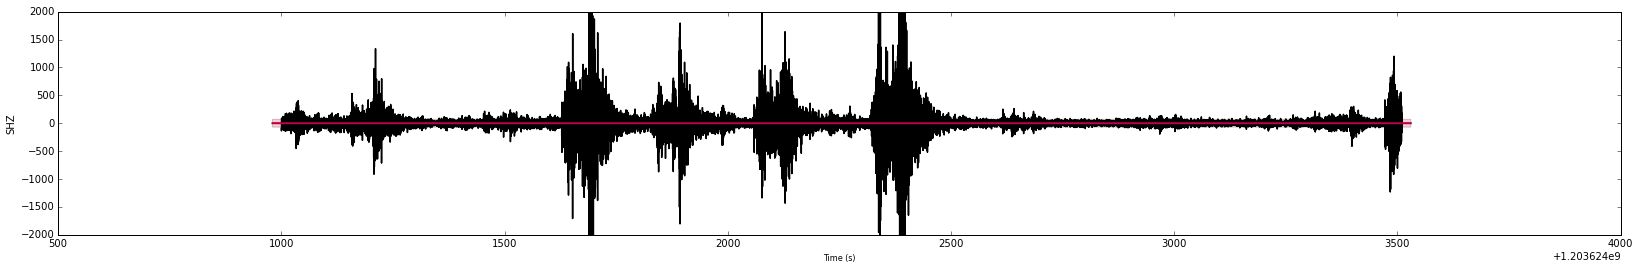

In [3]:

def plot_wn(wn):
    f = plt.figure(figsize=(28, 4))
    ax = f.add_subplot(111)
    
    wn.plot(ax=ax, plot_pred=True, plot_atimes=True, plot_stddev=True) # , xlim=xlim

    ax.set_ylim([-2000, 2000])
    
wn = sg.station_waves["NV01"][0]

target_evid = 1051106
target_ev = get_event(evid=target_evid)
#target_ev = Event(lon=-114.81 ,lat =41.17 , time= 1203628520.4, depth=1.6 , mb=2.8 )

plot_wn(wn)

In [4]:
print wn.log_p_old()

-767469.231002


In [5]:
wn.cached_logp = None
print wn.log_p()

-767469.231002


In [6]:
print np.sum(wn._cached_stepwise_ells)

-767469.231002


In [7]:
evnodes = sg.add_event(target_ev)


In [8]:
print wn.log_p()
print np.sum(wn._cached_stepwise_ells)

-693699.431077
-693699.431077


/home/dmoore/python/sigvisa/models/signal_model.py:631: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return TransientCombinedSSM(components, TSSM_NOISE_PADDING)


In [9]:
wn.cached_logp = None
print wn.log_p_old()

-693699.431077


In [10]:
run_open_world_MH(sg, steps=500,
                      enable_event_openworld=False,
                      enable_event_moves=True,
                      enable_phase_openworld=False,
                      enable_template_openworld=True,
                      enable_template_moves=True)

a must be non-empty
step 1: lp -487975.14, accepted arnoise_std: 0.000%, arrival_time: 0.375%, arrival_time_big: 0.375%, atime_xc: 0.000%, coda_decay: 0.500%, coda_height: 0.250%, coda_height_small: 0.250%, ev_lsqr: 0.500%, ev_source_type: 0.500%, evdepth: 1.000%, evloc: 1.000%, evloc_big: 0.000%, evmb: 1.000%, evtime: 0.000%, indep_peak: 0.000%, peak_decay: 0.500%, peak_offset: 0.438%, swap_association: 0.000%, template_xc: 0.000%, , uatemplates: 0 , events: 1 


-1
-1
a must be non-empty


KeyboardInterrupt: 

In [42]:
from sigvisa.utils.array import index_to_time, time_to_index, time_to_index_offset
from sigvisa.ssms_c import TransientCombinedSSM, ARSSM, CompactSupportSSM
TSSM_NOISE_PADDING=1e-6

def transient_ssm(self, arrivals=None, 
                  parent_values=None, 
                  save_components=True):

    # we allow specifying the list of parents in order to generate
    # signals with a subset of arriving phases (used e.g. in
    # wiggle extraction)
    if arrivals is None:
        arrivals = self.arrivals()

    arrivals = list(arrivals)
    n = len(arrivals)
    sidxs = np.empty((n,), dtype=int)
    envs = [None] * n
    min_logenv = max(-7.0, np.log(self.nm_env.c)-3)

    if self.wavelet_basis is not None:
        try:
            (start_idxs, end_idxs, identities, basis_prototypes, level_sizes, n_steps) = self.wavelet_basis
        except ValueError:
            (start_idxs, end_idxs, identities, basis_prototypes, level_sizes, n_steps), _ = self.wavelet_basis
        n_basis = len(start_idxs)
    else:
        n_steps = 0
        n_basis = 0



    components = [(self.noise_arssm, 0, self.npts, None)]

    tssm_components = [(None, None, None, 0, self.npts, "noise"),]

    # TODO: can be smarter about this, and only regenerate the TSSM when arrival_time changes.
    # Any other template param change can be implemented by just updating the scale vector in
    # the current TSSM to the new envelope.
    for (i, (eid, phase)) in enumerate(arrivals):
        v, tg = self.get_template_params_for_arrival(eid=eid, phase=phase, parent_values=parent_values)
        start_idx, offset = time_to_index_offset(v['arrival_time'], self.st, self.srate)
        sidxs[i] = start_idx
        if start_idx >= self.npts:
            continue

        env = np.exp(tg.abstract_logenv_raw(v, idx_offset=offset, srate=self.srate, min_logenv=min_logenv))
        if start_idx + len(env) < 0:
            continue

        wssm = self.arrival_ssms[(eid, phase)]

        npts = min(len(env), n_steps)

        if self.is_env:
            try:
                wiggle_std = np.abs(v['mult_wiggle_std'])
            except KeyError:
                wiggle_std = 0.5
        else:
            # in the raw signal case, wiggle std is unidentifiable with coda_height.
            wiggle_std = 1.0

        if (wssm is not None) and self.hack_wavelets_as_iid:
            assert (not self.is_env)

            wavelet_mean = wssm.mean_obs(npts)
            wavelet_std = np.sqrt(wssm.obs_var(npts))
            plt.figure()
            plt.plot(wavelet_mean)
            plt.plot(wavelet_mean + wavelet_std)
            plt.plot(wavelet_mean - wavelet_std)
            
            marginal_stds = env
            marginal_stds[:npts] *= wavelet_std
            components.append((self.iid_arssm, start_idx, len(env), marginal_stds))
            tssm_components.append((eid, phase, marginal_stds, start_idx, len(env), "multnoise"))
            
            pred_mean = wavelet_mean[:npts] * env[:npts]
            components.append((None, start_idx, npts, pred_mean))
            tssm_components.append((eid, phase, pred_mean, start_idx, npts, "pred_mean")) 
        else:
            if wssm is not None:
                components.append((wssm, start_idx, npts, env*wiggle_std))
                tssm_components.append((eid, phase, env*wiggle_std, start_idx, npts, "wavelet"))
            if len(env) > npts:
                n_tail = len(env)-npts
                mn_scale = env[npts:] * wiggle_std
                components.append((self.iid_arssm, start_idx+npts, len(env)-npts, mn_scale))
                tssm_components.append((eid, phase, mn_scale, start_idx+npts, len(env)-npts, "multnoise"))

        if self.is_env:
            components.append((None, start_idx, len(env), env))
            tssm_components.append((eid, phase, env, start_idx, len(env), "template"))

    if save_components:
        self.tssm_components=tssm_components
    return TransientCombinedSSM(components, TSSM_NOISE_PADDING)

In [48]:
wn.hack_wavelets_as_iid=True

wn._set_cssm_priors_from_model()

tssm = transient_ssm(wn)

/home/dmoore/.virtualenvs/sigvisa/lib/python2.7/site-packages/IPython/kernel/__main__.py:98: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


reading station detections... 
-320588.912366
0.0267109870911


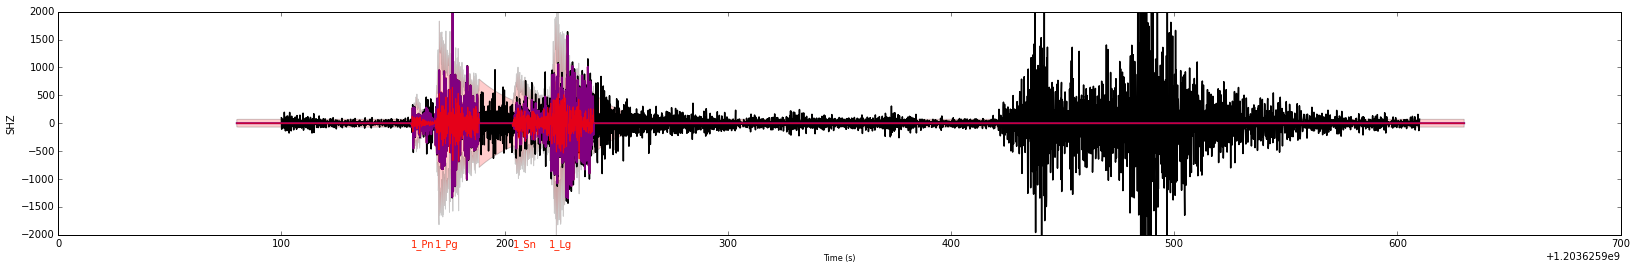

In [34]:
#plot_wn(wn)
t0 = time.time()
lp = tssm.run_filter(d)
t1 = time.time()
print lp
print t1-t0

-320280.088001
0.00453615188599


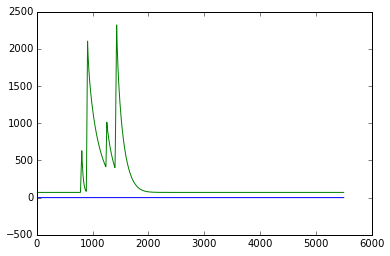

In [49]:
#plot_wn(wn)
t0 = time.time()
lp = tssm.run_filter(d)
t1 = time.time()
pred_mean = tssm.mean_obs(wn.npts)
pred_std = np.sqrt(tssm.obs_var(wn.npts))
print lp
print t1-t0
plt.plot(pred_mean)
plt.plot(pred_mean + 2*pred_std)

In [ ]:
with open("/home/dmoore/python/sigvisa/notebooks/thesis/corr_uatemplate_test.sg",  'rb') as f:
    sg = pickle.load(f)
sg.current_log_p_breakdown()

In [6]:
print target_ev

evid 1051106.0, loc 114.90 W 41.14 N, depth 10.7km, time 1203625999.7, mb 2.5, natural source


In [62]:
A = np.random.randn(150, 150)
M = np.dot(A, A.T)


In [63]:
t0 = time.time()
Z = np.linalg.inv(M)
t1 = time.time()

In [64]:
print t1-t0

0.00995397567749
